In [1]:
from cnn.model import build_net

from spleen_dataset.dataloader import SpleenDataloader, SpleenDataset, get_training_augmentation, get_validation_augmentation
from spleen_dataset.config import dataset_folder
from spleen_dataset.utils import get_split_deterministic, get_list_of_patients

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import random
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
  except RuntimeError as e:
    print(e)

2022-08-22 18:44:01.850562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 18:44:01.917694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 18:44:01.917814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
patients = get_list_of_patients(dataset_folder)

In [3]:
patch_size = (128, 128)
batch_size = 32
num_classes = 2
train_augmentation = get_training_augmentation(patch_size)
val_augmentation = get_validation_augmentation(patch_size)

net_list = [
    'vgg_3_64', 
    'vgg_3_128',
    'vgg_3_256',
    'vgg_3_512',
    'vgg_3_1024',
    'vgg_3_512',
    'vgg_3_256',
    'vgg_3_128',
    'vgg_3_64'
]

fn_dict = {
    'vgg_1_32':        {'block': 'VGGBlock',    'params': {'kernel': 1, 'filters': 32},     'prob': 1/36},
    'vgg_1_64':        {'block': 'VGGBlock',    'params': {'kernel': 1, 'filters': 64},     'prob': 1/36},
    'vgg_1_128':       {'block': 'VGGBlock',    'params': {'kernel': 1, 'filters': 128},    'prob': 1/36},
    'vgg_1_256':       {'block': 'VGGBlock',    'params': {'kernel': 1, 'filters': 256},    'prob': 1/36},
    'vgg_1_512':       {'block': 'VGGBlock',    'params': {'kernel': 1, 'filters': 512},    'prob': 1/36},
    'vgg_1_1024':      {'block': 'VGGBlock',    'params': {'kernel': 1, 'filters': 1024},   'prob': 1/36},

    'vgg_3_32':        {'block': 'VGGBlock',    'params': {'kernel': 3, 'filters': 32},     'prob': 1/36},
    'vgg_3_64':        {'block': 'VGGBlock',    'params': {'kernel': 3, 'filters': 64},     'prob': 1/36},
    'vgg_3_128':       {'block': 'VGGBlock',    'params': {'kernel': 3, 'filters': 128},    'prob': 1/36},
    'vgg_3_256':       {'block': 'VGGBlock',    'params': {'kernel': 3, 'filters': 256},    'prob': 1/36},
    'vgg_3_512':       {'block': 'VGGBlock',    'params': {'kernel': 3, 'filters': 512},    'prob': 1/36},
    'vgg_3_1024':      {'block': 'VGGBlock',    'params': {'kernel': 3, 'filters': 1024},   'prob': 1/36},

    'vgg_5_32':        {'block': 'VGGBlock',    'params': {'kernel': 5, 'filters': 32},     'prob': 1/36},
    'vgg_5_64':        {'block': 'VGGBlock',    'params': {'kernel': 5, 'filters': 64},     'prob': 1/36},
    'vgg_5_128':       {'block': 'VGGBlock',    'params': {'kernel': 5, 'filters': 128},    'prob': 1/36},
    'vgg_5_256':       {'block': 'VGGBlock',    'params': {'kernel': 5, 'filters': 256},    'prob': 1/36},
    'vgg_5_512':       {'block': 'VGGBlock',    'params': {'kernel': 5, 'filters': 512},    'prob': 1/36},
    'vgg_5_1024':      {'block': 'VGGBlock',    'params': {'kernel': 5, 'filters': 1024},   'prob': 1/36},

    'resnet_1_32':     {'block': 'ResNetBlock', 'params': {'kernel': 1, 'filters': 32},     'prob': 1/36},
    'resnet_1_64':     {'block': 'ResNetBlock', 'params': {'kernel': 1, 'filters': 64},     'prob': 1/36},
    'resnet_1_128':    {'block': 'ResNetBlock', 'params': {'kernel': 1, 'filters': 128},    'prob': 1/36},
    'resnet_1_256':    {'block': 'ResNetBlock', 'params': {'kernel': 1, 'filters': 256},    'prob': 1/36},
    'resnet_1_512':    {'block': 'ResNetBlock', 'params': {'kernel': 1, 'filters': 512},    'prob': 1/36},
    'resnet_1_1024':   {'block': 'ResNetBlock', 'params': {'kernel': 1, 'filters': 1024},   'prob': 1/36},

    'resnet_3_32':     {'block': 'ResNetBlock', 'params': {'kernel': 3, 'filters': 32},     'prob': 1/36},
    'resnet_3_64':     {'block': 'ResNetBlock', 'params': {'kernel': 3, 'filters': 64},     'prob': 1/36},
    'resnet_3_128':    {'block': 'ResNetBlock', 'params': {'kernel': 3, 'filters': 128},    'prob': 1/36},
    'resnet_3_256':    {'block': 'ResNetBlock', 'params': {'kernel': 3, 'filters': 256},    'prob': 1/36},
    'resnet_3_512':    {'block': 'ResNetBlock', 'params': {'kernel': 3, 'filters': 512},    'prob': 1/36},
    'resnet_3_1024':   {'block': 'ResNetBlock', 'params': {'kernel': 3, 'filters': 1024},   'prob': 1/36},

    'resnet_5_32':     {'block': 'ResNetBlock', 'params': {'kernel': 5, 'filters': 32},     'prob': 1/36},
    'resnet_5_64':     {'block': 'ResNetBlock', 'params': {'kernel': 5, 'filters': 64},     'prob': 1/36},
    'resnet_5_128':    {'block': 'ResNetBlock', 'params': {'kernel': 5, 'filters': 128},    'prob': 1/36},
    'resnet_5_256':    {'block': 'ResNetBlock', 'params': {'kernel': 5, 'filters': 256},    'prob': 1/36},
    'resnet_5_512':    {'block': 'ResNetBlock', 'params': {'kernel': 5, 'filters': 512},    'prob': 1/36},
    'resnet_5_1024':   {'block': 'ResNetBlock', 'params': {'kernel': 5, 'filters': 1024},   'prob': 1/36},
}

2022-08-22 18:44:45.238631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 18:44:45.240339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 18:44:45.240464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 18:44:45.240547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

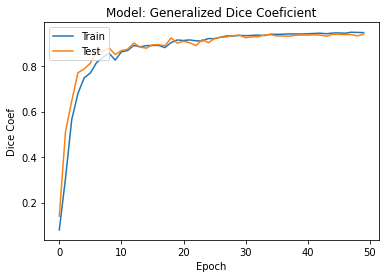

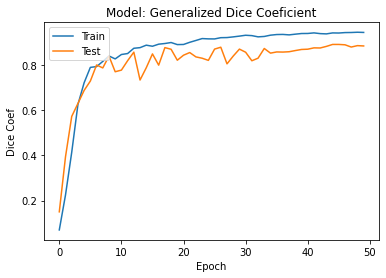

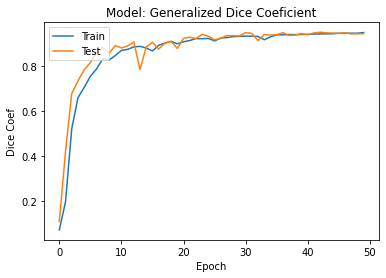

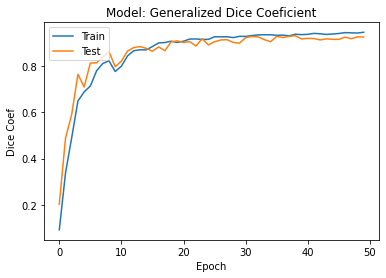

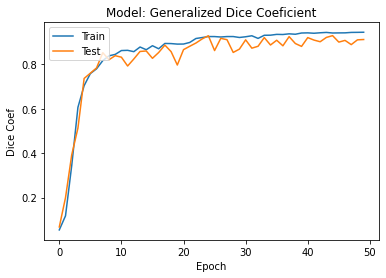

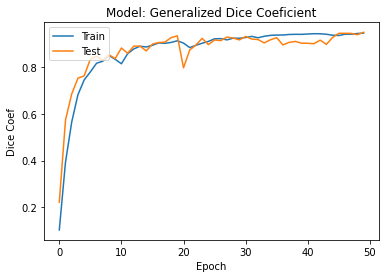

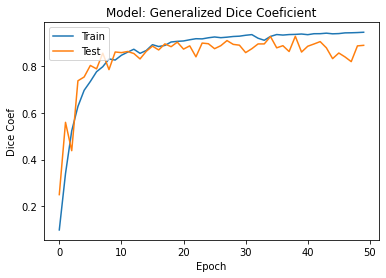

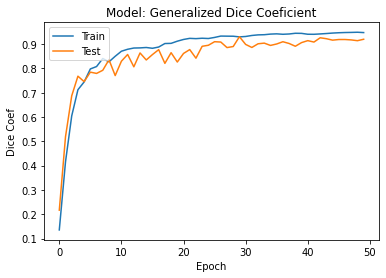

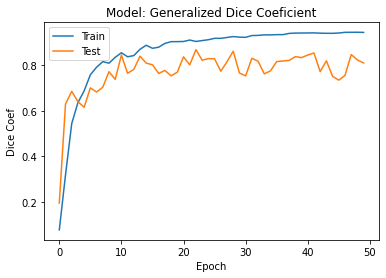

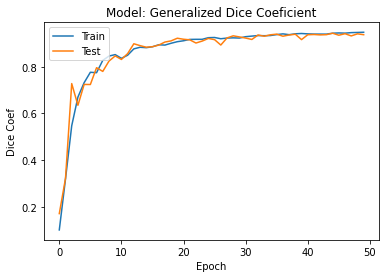

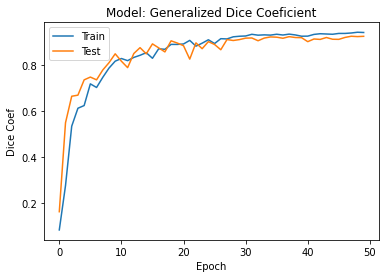

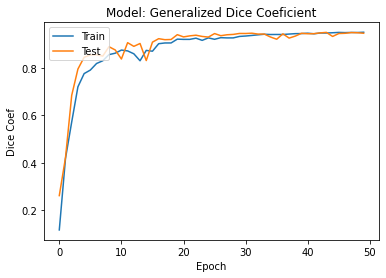

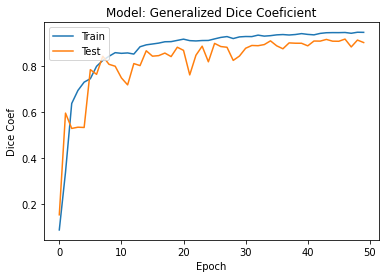

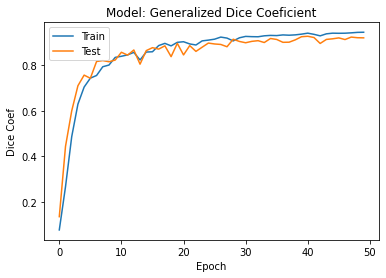

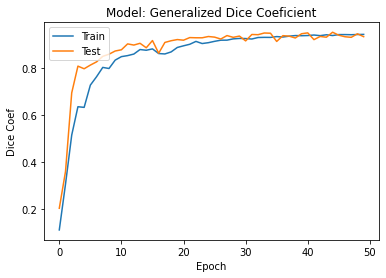

Dice 0.9117897220452628 +- 0.03575238218958195


In [4]:
val_gen_dice_coef_list = []
num_splits = 5
num_initializations = 3
epochs = 50
metric_epochs = 10

for initialization in range(num_initializations):

    for fold in range(num_splits):
        train_patients, val_patients = get_split_deterministic(patients, fold=fold, num_splits=num_splits, random_state=initialization)

        train_dataset = SpleenDataset(train_patients, only_non_empty_slices=True)
        val_dataset = SpleenDataset(val_patients, only_non_empty_slices=True)

        train_dataloader = SpleenDataloader(train_dataset, batch_size, train_augmentation)
        val_dataloader = SpleenDataloader(val_dataset, batch_size, val_augmentation)

        model = build_net((*patch_size, 1), num_classes, fn_dict, net_list)

        history = model.fit(
            train_dataloader,
            validation_data=val_dataloader,
            epochs=epochs,
            verbose=0,
        )

        val_gen_dice_coef = np.mean(history.history['val_gen_dice_coef'][-metric_epochs:])

        val_gen_dice_coef_list.append(val_gen_dice_coef)

        # plotting the dice coef results (accuracy) as a function of the number of epochs
        plt.figure()
        plt.plot(history.history['gen_dice_coef'])
        plt.plot(history.history['val_gen_dice_coef'])
        plt.title('Model: Generalized Dice Coeficient')
        plt.ylabel('Dice Coef')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # plotting the dice coeff results (loss function) as a function of the number of epochs
        # plt.figure()
        # plt.plot(history.history['loss'])
        # plt.plot(history.history['val_loss'])
        # plt.title('Model: Generalized Dice Coeficient')
        # plt.ylabel('Dice Loss')
        # plt.xlabel('Epoch')
        # plt.legend(['Train', 'Test'], loc='upper right')
        # plt.show()

mean_val_gen_dice_coef = (np.mean(val_gen_dice_coef_list))
std_val_gen_dice_coef = (np.std(val_gen_dice_coef_list))

print(f'Dice {mean_val_gen_dice_coef} +- {std_val_gen_dice_coef}')

In [5]:
#!tensorboard --logdir='./logs'